In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
!pwd

/Users/kn119/Documents/MSc/cardiolearning/fenton_karma_jax-master/tests


In [7]:
import os
from fk import params
# from fk import model
from fk import convert
from fk import stimulus
import matplotlib.pyplot as plt
import jax
import jax.numpy as np



# Instead of importing model
import os

os.chdir("../fk")

import model

os.chdir("../tests")
# 

In [8]:
# simulation inputs (real values)
field_size = (12, 12)  # cm
d = 0.001  # (cm^2/ms)
cell_parameters = params.params2()

# infinitesimals
dx = 0.01  # (cm/units) - Fenton 1998 recommends ~200, 300 micron/gridunit (~0.02, 0.03), smaller dx means finer grid
dt = 0.01  # (ms) - Fenton 1998 recommends few hundreds of ms (~0.01, 0.04)

In [9]:
def show_stimuli(*stimuli, **kwargs):
    fig, ax = plt.subplots(1, len(stimuli), figsize=(kwargs.pop("figsize", None) or (10, 3)))
    vmin = kwargs.pop("vmin", -1)
    vmax = kwargs.pop("vmax", 1)
    cmap = kwargs.pop("cmap", "RdBu")
    for i, stimulus in enumerate(stimuli):
        im = ax[i].imshow(stimulus["field"], vmin=vmin, vmax=vmax, cmap=cmap, **kwargs)
        plt.colorbar(im, ax=ax[i])
        ax[i].set_title("Stimulus %d" % i)
    plt.show()
    return

def show(state, **kwargs):
    fig, ax = plt.subplots(1, 3, figsize=(kwargs.pop("figsize", None) or (10, 3)))
    vmin = kwargs.pop("vmin", -1)
    vmax = kwargs.pop("vmax", 1)
    cmap = kwargs.pop("cmap", "RdBu")
    im = ax[0].imshow(state[0], vmin=vmin, vmax=vmax, cmap=cmap, **kwargs)
    plt.colorbar(im, ax=ax[0])
    ax[0].set_title("v")
    im = ax[1].imshow(state[1], vmin=vmin, vmax=vmax, cmap=cmap, **kwargs)
    plt.colorbar(im, ax=ax[1])
    ax[1].set_title("w")
    im = ax[2].imshow(state[2], vmin=vmin, vmax=vmax, cmap=cmap, **kwargs)
    plt.colorbar(im, ax=ax[2])
    ax[2].set_title("u")
    plt.show()
    return fig, ax

def show_conductivity(*stimuli, **kwargs):
    fig, ax = plt.subplots(1, len(stimuli), figsize=(kwargs.pop("figsize", None) or (10, 3)))
    vmin = kwargs.pop("vmin", -1)
    vmax = kwargs.pop("vmax", 1)
    cmap = kwargs.pop("cmap", "RdBu")
    for i, stimulus in enumerate(stimuli):
        im = ax[i].imshow(stimulus["field"], vmin=vmin, vmax=vmax, cmap=cmap, **kwargs)
        plt.colorbar(im, ax=ax[i])
        ax[i].set_title("Stimulus %d" % i)
    plt.show()
    return

/opt/anaconda3/envs/cardio/lib/python3.7/site-packages/jax/lib/xla_bridge.py:125: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


(1200, 1200)
real tissue size: (12, 12)
{'tau_v_plus': 10, 'tau_v1_minus': 10, 'tau_v2_minus': 10, 'tau_w_plus': 1000000.0, 'tau_w_minus': 1000000.0, 'tau_d': 0.25, 'tau_0': 10, 'tau_r': 190, 'tau_si': 1000000.0, 'k': 100000, 'V_csi': 1000000.0, 'V_c': 0.13, 'V_v': 1000000.0, 'Cm': 1}


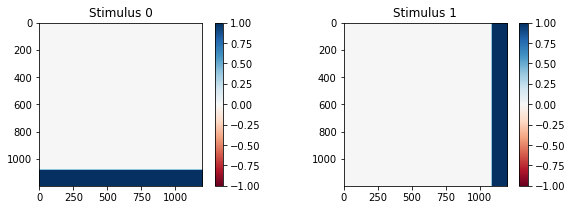

In [10]:
# to computational units
shape = convert.realsize_to_shape(field_size, dx)

stripe_size = int(shape[0] / 10)

protocol1 = stimulus.protocol(start=0, duration=2, period=0)
s1 = stimulus.rectangular(shape, (shape[0]-stripe_size/2,shape[0]/2), (stripe_size, shape[1]), 1., protocol1)

protocol2 = stimulus.protocol(start=25000, duration=2, period=0)
s2 = stimulus.rectangular(shape, (shape[1]/2, shape[0]-stripe_size/2), (shape[1], stripe_size), 1., protocol2)

# protocol3 = stimulus.protocol(start=20000, duration=2, period=0)
# s3 = stimulus.rectangular(shape, jax.ops.index[stripe_size*2:stripe_size*4, stripe_size*2:stripe_size*4], 1., protocol3)

# protocol4 = stimulus.protocol(start=30000, duration=2, period=0)
# s4 = stimulus.rectangular(shape, jax.ops.index[stripe_size*4:stripe_size*5, :], 1., protocol4)

stimuli = [s1, s2]

print(shape)
print("real tissue size:", field_size)
print(cell_parameters)
show_stimuli(*stimuli)

Updated!
100


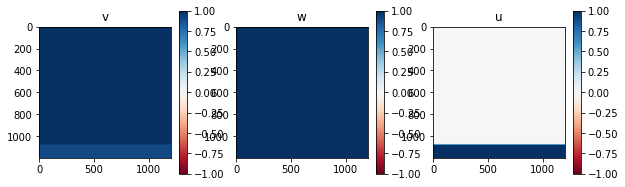

500


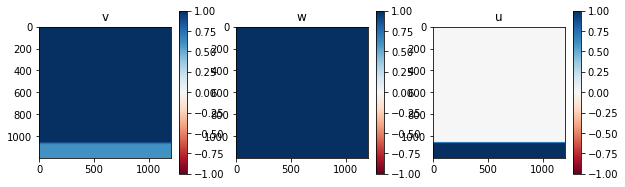

1000


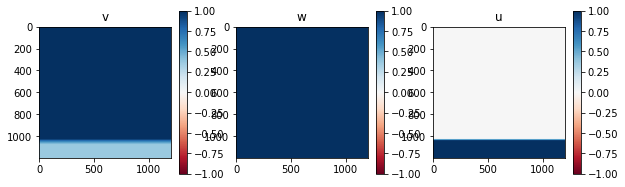

In [7]:
checkpoints = [0,100, 500, 1000]
state = model.init(shape)
for i in range(len(checkpoints) - 1):
    state = model._forward(state, checkpoints[i], checkpoints[i + 1], cell_parameters, np.ones(shape) * d, stimuli, dt, dx)  # dt = 10000
    print(checkpoints[i + 1])
    show(state)

In [25]:
active = np.greater_equal(10, s1["start"])
print(active)
active &= np.greater_equal(s1["start"]+s1["duration"],10)
print(active)

True
False


In [28]:
np.mod( s1["start"]-2+1, 1e9)

DeviceArray(1.e+09, dtype=float32)

In [22]:
(s1['start']-2+1)

-1